**Lets create some code 💪🔑🌐**

Read data and add to dataframe

Shafts-data comes from htlm file of http://www.zechenkarte.de/wiki/index.php?title=Gesamtkarte

Mine data comes from the xlsx file, where the data starts from line 5.

In [ ]:
!pip install fuzz
!pip install fuzzywuzzy
!pip install pandas as pd
!pip install json
!pip install csv
!pip install rdflib
!pip install folium
!pip install matplotlib
!pip install mapclassify

In [5]:
import pandas as pd
from pandas import json_normalize
import openpyxl
from fuzzywuzzy import fuzz

import json
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

from rdflib import Graph, Literal, Namespace, RDF, URIRef
from rdflib.namespace import GEO, XSD, RDF

In [6]:
# Import data form the excel sheet

file_path = 'C:/Users/rohne/Documents/LDAC/LDAC2024/data/Steinkohlenzechen_NRW.xlsx'  # Adjust the path as needed
excel_file = pd.ExcelFile(file_path)

# Iterate through all sheet names
#sheets_data ={}
dataframe = []
for sheet_name in excel_file.sheet_names:
    # Read the sheet starting from the 5th line (index 4) with the 5th line as header (index 4)
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=4)
    df['year']=sheet_name
    dataframe.append(df)

mines = pd.concat(dataframe, ignore_index=True)

    # Store the DataFrame in the dictionary
    #sheets_data[sheet_name] = shafts

In [7]:
#Read data from the html file

shafts_path = 'data/Mines_all_small.json'
with open(shafts_path) as f:
    data = json.load(f)
shafts = json_normalize(data['locations'])

# print(mines.Mine)
# print(shafts.title)

In [8]:
#Data preparation, Add additional Table for fuzzy 
shafts['title_fuzzy']=shafts['title']
shafts['title_fuzzy'] = shafts['title_fuzzy'].str.replace(' Schacht', '', case=False)
shafts['title_fuzzy'] = shafts['title_fuzzy'].str.strip()

mines['title_fuzzy']=mines['Name des Bergwerks']
words_to_remove = ['Gewerkschaft', 'Zeche', 'ver.', 'Bergwerk', 'Bergbau', 'Aktien', 'Gesellschaft']
pattern = '|'.join(words_to_remove)
mines['title_fuzzy'] = mines['title_fuzzy'].str.replace(pattern, '', case=False, regex=True)
mines['title_fuzzy'] = mines['title_fuzzy'].str.strip()

In [9]:
# Function to compute similarity and group mines
def group_similar_titles(mines, threshold=85):
    # List to store group indices
    groups = [-1] * len(mines)
    group_id = 0
    
    # Iterate over each title to compare it with others
    for i in range(len(mines)):
        if groups[i] == -1:  # If not already assigned to a group
            groups[i] = group_id
            for j in range(i + 1, len(mines)):
                if groups[j] == -1:  # If not already assigned to a group
                    similarity_score = fuzz.ratio(str(mines.loc[i, 'title_fuzzy']+ ' '+mines.loc[i,'Ort']),str(mines.loc[j, 'title_fuzzy']+ ' '+mines.loc[j,'Ort']))
                
                    if similarity_score >= threshold:
                        groups[j] = group_id
                        #print(mines.loc[i, 'title_fuzzy'],',', mines.loc[j, 'title_fuzzy'],'->', similarity_score)
            group_id += 1
    
    return groups

# Apply the function to group similar titles
mines['mine_group'] = group_similar_titles(mines)

In [10]:
# Define a function to concatenate unique values while handling NaNs
def concat_unique(series):
    unique_values = series.dropna().unique()  # Drop NaNs and get unique values
    return ', '.join(unique_values) if unique_values.size > 0 else None

mines_only = mines.copy()
mines_only = mines_only.groupby('mine_group').agg(
    title = ('Name des Bergwerks', 'first')
    ,ort = ('Ort','first')
    ,revier = ('Revier','first')
    ,title_fuzzy = ('title_fuzzy','first')
    ,weitere_informationen = ('weitere Informationen',concat_unique)  # Additional information

    #company_form =('Unternehmensform','first')
    ).reset_index()

In [11]:
# Define a function to compute string similarity
def compute_similarity(string1, string2):
    return fuzz.ratio(string1, string2)  # You can use other similarity metrics here

matches = []
for index1, row1 in mines_only.iterrows():
    for index2, row2 in shafts.iterrows():
        similarity_score = compute_similarity(row1['title_fuzzy'], row2['title_fuzzy']) 
        if similarity_score >= 60:  # Set a threshold for similarity
            matches.append((index1, index2, similarity_score))

matches_df = pd.DataFrame(matches, columns=['index_mines_group', 'index_shafts', 'similarity_score'])
           
# Output matches
if len(matches) == 0:
    print("No matches found.")
else:
    print("Matches found:", len(matches))

Matches found: 1018


In [ ]:
# Create ttl file for mines 
#
EX = Namespace("http://example.org/")
#GEO = Namespace("http://www.geonames.org/ontology#")
SCHEMA = Namespace("http://schema.org/")
GEO = Namespace("http://www.opengis.net/ont/geosparql#")

# Create an RDF graph
g = Graph()
g.remove((None, None, None))
g.bind("ex", EX)
g.bind("geo", GEO)
g.bind("schema", SCHEMA)

for index, row in mines_only.iterrows():

    title = row.title
    ort = row.ort
    revier = row.revier
    UID_mine = row.mine_group
    weitere_informationen = row.weitere_informationen

    mine_uri = URIRef(EX + "mine/"+ str(UID_mine))
    
    g.add((mine_uri, RDF.type, EX.Mine))
    g.add((mine_uri, EX.name, Literal(title)))
    g.add((mine_uri, GEO.location, Literal(ort)))
    g.add((mine_uri, SCHEMA.Place, Literal(revier)))
    g.add((mine_uri, EX.info, Literal(weitere_informationen)))
    
ttl_file = 'data/output/mines.ttl'
g.serialize(destination=ttl_file, format='turtle')

In [13]:
materials = mines.copy()
materials['Koksproduktion'] = materials['Koksproduktion in Tonnen (1906)'].fillna(materials['Koksproduktion in Tonnen'])
materials['Förderung'] = materials['Förderung in Tonnen (1906)'].fillna(materials['Förderung in Tonnen'])

In [ ]:

# Materials
EX = Namespace("http://example.org/")
GEO = Namespace("http://www.opengis.net/ont/geosparql#")
SCHEMA = Namespace("http://schema.org/")

# Create an RDF graph
g = Graph()
g.remove((None, None, None))
g.bind("ex", EX)
g.bind("schema", SCHEMA)

for index, row in materials.iterrows():
    title = row['abgebauter Rohstoff']  # Material name
    #ort = row['Ort']  # Location
    #revier = row['Revier']  # Mining district
    unternehmensform = row['Unternehmensform']  # Company type
    syndikatsbeteiligung = row['Syndikatsbeteiligung']  # Syndicate participation
    #foerderung_1906 = row['Förderung in Tonnen (1906)']  # Production in tons (1906)
    kohlensorte = row['Kohlensorte']  # Coal type
    kokssorte = row['Kokssorte']  # Coke type
    #koksproduktion_1906 = row['Koksproduktion in Tonnen (1906)']  # Coke production in tons (1906)
    sonstige_nebenprodukte = row['sonstige Nebenprodukte']  # Other by-products
    #seite = row['Seite']  # Page number
    year = row['year']  # Year
    foerderung = row['Förderung']  # Production in tons
    koksproduktion = row['Koksproduktion']  # Coke production in tons
    UID_mine = row.mine_group
    mine_uri = URIRef(EX + "mine/"+ str(UID_mine))

    # Create URI for the material
    material_uri = URIRef(EX +"material/" + str(row['mine_group']) + "/" + str(row['year']) ) # Using material name as URI, adjust as needed

    # Add triples to the RDF graph
    g.add((material_uri, RDF.type, EX.Material))
    g.add((material_uri, EX.name, Literal(title)))
    #g.add((material_uri, GEO.name, Literal(ort)))
    #g.add((material_uri, SCHEMA.Place, Literal(revier)))
    g.add((material_uri, EX.Unternehmensform, Literal(unternehmensform)))
    g.add((material_uri, EX.Syndikatsbeteiligung, Literal(syndikatsbeteiligung)))
    g.add((material_uri, EX.Kohlensorte, Literal(kohlensorte)))
    g.add((material_uri, EX.Kokssorte, Literal(kokssorte)))
    g.add((material_uri, EX.sonstige_Nebenprodukte, Literal(sonstige_nebenprodukte)))
    #g.add((material_uri, EX.Seite, Literal(seite)))
    g.add((material_uri, SCHEMA.year, Literal(year,datatype=XSD.gYear)))
    g.add((material_uri, EX.foerderung, Literal(foerderung)))
    g.add((material_uri, EX.koksproduktion, Literal(koksproduktion)))
    g.add((mine_uri, EX.hasMaterial, material_uri))
    g.add((material_uri, EX.hasMine, mine_uri))

ttl_file = 'data/output/mines_materials.ttl'
g.serialize(destination=ttl_file, format='turtle')



In [ ]:
# Create ttl file for shafts
# Define namespaces
EX = Namespace("http://example.org/")
GEO = Namespace("http://www.opengis.net/ont/geosparql#")

# Create an RDF graph
g = Graph()
g.remove((None, None, None))
g.bind("ex", EX)
g.bind("geo", GEO)

# Process each entry in the JSON data
for index, row in shafts.iterrows():

    title_item = row.title
    latitude = row.lat
    longitude = row.lon
    
    # Create URI for the title and geometry
    title_uri = EX["http://www.zechenkarte.de/wiki/index.php?title=" + title_item.replace(" ", "_")]
    geom_uri = EX[title_item.replace(" ", "_") + "Geom"]
    
    # Add RDF triples to the graph
    g.add((title_uri, RDF.type, EX.Schacht))
    g.add((title_uri, EX.name, Literal(title_item)))
    g.add((title_uri, GEO.hasGeometry, geom_uri))
    
    g.add((geom_uri, RDF.type, GEO.Geometry))
    g.add((geom_uri, GEO.asWKT, Literal(f"POINT({longitude} {latitude})", datatype=GEO.wktLiteral)))

    matches_filtered = matches_df[matches_df.index_shafts == index]
    if not matches_filtered.empty:
        for _, match_row in matches_filtered.iterrows(): 
            UID_mine = match_row["index_mines_group"]
        
            mine_uri = URIRef(EX + "mine/"+ str(UID_mine))


            g.add((mine_uri, EX.hasShafts, title_uri))
            g.add((title_uri, EX.hasMine, mine_uri))

# Serialize the graph to a TTL file
g.serialize(destination='data/output/shafts.ttl', format='turtle')

#print("TTL file created successfully.")


See an example outcome of the query file: 

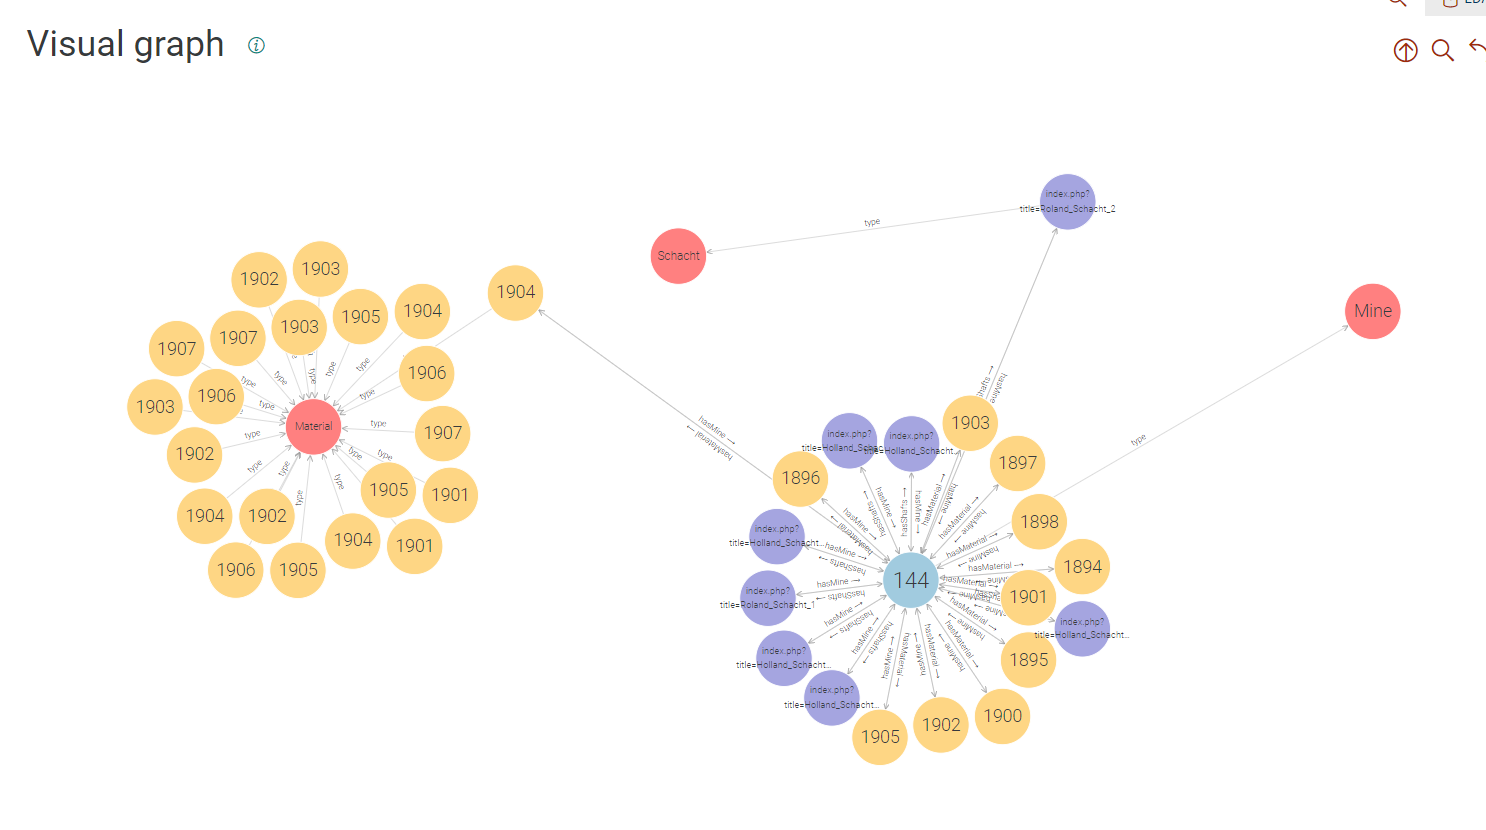

In [35]:
##Query to get shafts and mines
import geopandas as gpd
from shapely.geometry import Point
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, GEO

# Define namespaces
EX = Namespace("http://example.org/")
GEO = Namespace("http://www.opengis.net/ont/geosparql#")

# Load the RDF graph from the TTL file
g = Graph()
g.parse("data/output/shafts.ttl", format="turtle")
g.parse("data/output/mines.ttl", format="turtle")

# Define the SPARQL query
query = """
PREFIX ex: <http://example.org/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>

SELECT ?schacht ?name ?hasmine ?minename ?wkt ?ort
WHERE {
  ?schacht a ex:Schacht ;
           ex:name ?name ;
           ex:hasMine ?hasmine;
           geo:hasGeometry ?geom .
  ?geom geo:asWKT ?wkt .
  ?hasmine ex:name ?minename;
          geo:location ?ort.
}
"""

# Execute the query
results = g.query(query)

In [ ]:
# Prepare data for GeoDataFrame
data = []
for row in results:
    schacht_uri = str(row.schacht)
    mine_name = str(row.minename)
    name = str(row.name).strip()
    wkt = str(row.wkt)
    ort = str(row.ort)
    
    # Convert WKT to shapely geometry
    geometry = Point(float(wkt.split('(')[1].split()[0]), float(wkt.split('(')[1].split()[1][:-1]))
    
    data.append({"schacht_uri": schacht_uri, "name": name, "mine_name": mine_name,"ort":ort, "geometry": geometry})

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry="geometry")
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=32632)

# Save the GeoDataFrame to a shapefile
gdf.to_file("data/output/schachts.shp", driver='ESRI Shapefile')
gdf.to_file('data/output/schachts.geojson', driver='GeoJSON')  

print("Data extraction and shapefile creation complete.")


In [43]:
gdf.explore()

In [54]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# Read the shapefile into a GeoDataFrame
shafts = gpd.read_file("data/output/schachts.shp")
shafts = shafts.loc[shafts.ort == 'Bochum']

# Group the points by mine_name and combine points into LineStrings
grouped = shafts.groupby('mine_name')['geometry'].apply(lambda x: LineString(x.tolist()) if len(x) > 1 else x.iloc[0])

# Convert LineStrings to Polygons
def line_to_polygon(geom):
    if isinstance(geom, LineString) and len(geom.coords) > 2:
        return Polygon(geom)
    else:
        return None  # Return None for non-polygon geometries

# Apply the conversion function
polygons = grouped.apply(line_to_polygon)

# Filter out None values (non-polygon geometries)
polygons = polygons.dropna()

# Create a new GeoDataFrame with the polygons
polygon_gdf = gpd.GeoDataFrame(polygons, columns=['geometry'])

# Reset index to have 'mine_name' as a column
polygon_gdf = polygon_gdf.reset_index()
polygon_gdf = polygon_gdf.set_crs(epsg=4326, allow_override=True)
polygon_gdf = polygon_gdf.to_crs(epsg=32632)

# Save to a new shapefile
polygon_gdf.to_file("data/output/mines_polygons.shp", driver="ESRI Shapefile")
polygon_gdf.to_file('data/output/mines_polygons.geojson', driver='GeoJSON')  
# Display the GeoDataFrame



In [55]:
polygon_gdf.explore()

In [20]:
#Query to get material


# Define namespaces
EX = Namespace("http://example.org/")
GEO = Namespace("http://www.opengis.net/ont/geosparql#")
SCHEMA = Namespace("http://schema.org/")

# Load the RDF graph from the TTL file
g = Graph()
g.parse("data/output/shafts.ttl", format="turtle")
g.parse("data/output/mines.ttl", format="turtle")
g.parse("data/output/mines_materials.ttl", format="turtle")

# Define the SPARQL query
query = """
PREFIX ex: <http://example.org/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX schema: <http://schema.org/>

SELECT ?mine_name  ?material ?cole_type ?coks_type ?fostering ?production ?materialname ?year
WHERE {


  ?material a ex:Material ;
    		   
               ex:Kohlensorte ?cole_type ;
               ex:Kokssorte ?coks_type ;
               ex:foerderung ?fostering ;
               ex:hasMine ?hasmine ;
               ex:koksproduktion ?production ;
               ex:name ?materialname ;
               schema:year ?year .
  ?hasmine ex:name ?mine_name.

}
"""

# Execute the query
results = g.query(query)

In [ ]:
data = []
for row in results:
    mine_name, material, cole_type, coks_type, fostering, production, materialname, year = row
    data.append([
        str(mine_name),  str(material), str(cole_type),
        str(coks_type), str(fostering), str(production), str(materialname), str(year)
    ])

# Create a DataFrame
df = pd.DataFrame(data, columns=[
    'Mine_Name',  'Material', 'Cole_Type', 
    'Coks_Type', 'Fostering', 'Production', 'MaterialName', 'Year'
])

# df.to_file("materials.shp", driver="ESRI Shapefile")
# df.to_file('materials.geojson', driver='GeoJSON')  